## _Install librairies for processing Medical Images_

In [1]:
# !pip install imageio

In [2]:
# !pip install pydicom python-gdcm

In [3]:
# !pip install pylibjpeg pylibjpeg-libjpeg pydicom

In [4]:
# !pip install python-gdcm

In [5]:
# !pip install nibabel

## _Import Librairies & Dependencis_

In [6]:
import sys
import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)


In [7]:
# DATA MANIPULATION
import random
import numpy as np
import pandas as pd
import pandas.api.types
from scipy import stats
import scipy.ndimage as ndi

# DATA VISUALIZATION - PLOTS
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline


# IMAGE PREPROCESSING & VISUALIZATION
import time
import cv2
import os, shutil

import gdcm 
import imageio as iio
import nibabel as nib
import pydicom as dicom
import SimpleITK as sitk
import albumentations as A
import ipywidgets as widgets

from PIL import * 
from skimage import * 
from pydicom import *
from glob import glob
from tqdm import tqdm
from pathlib import Path
from pydicom.data import *
from skimage.filters import *
from skimage.exposure import *
from skimage.transform import *
from subprocess import check_output

## 1.  _Processsing the main directories and files_

In [8]:
# Set dataset root
dsroot ='/home/mukwa/Desktop/rsna-2023-abdominal-trauma-detection/'

In [9]:
!ls {dsroot}

image_level_labels.csv	 test_images		   train_images
sample_submission.csv	 test_series_meta.csv	   train_series_meta.csv
segmentations		 train.csv
test_dicom_tags.parquet  train_dicom_tags.parquet


## _Load nibabel (3D images) and dicom (2D images) directories_

In [10]:
# Define the directory paths for the segmentation and train images
train_images = os.path.join(dsroot, 'train_images')
nib_img_dir = os.path.join(dsroot, 'segmentations/')

In [11]:
# Get the list of image file names in the directory
seg_nib_img = os.listdir(nib_img_dir)

# Initialize a counter for the number of files with a different orientation
count = 0

# Loop over all the NIfTI images and increment the counter if their orientation is different from R', 'A', 'S'
for nii_scan in seg_nib_img:
    # Load the nibabel image
    nifti_img = nib.load(os.path.join(nib_img_dir, nii_scan))

    # Get the orientation of the image
    orientation = nib.aff2axcodes(nifti_img.affine)

    # Check if the orientation is different from R', 'A', 'S'
    if orientation != ('R', 'A', 'S'):
            count += 1

# Print a message indicating the total count of files with a different orientation
if count > 0:
    print(f"{count} images have a different orientation than R', 'A', or 'S'.")
    print(f"\nThe orientation of the images  is {orientation}.")
else:
    print("All files have the same orientation.")

206 images have a different orientation than R', 'A', or 'S'.

The orientation of the images  is ('L', 'A', 'S').


--------------

# 2. _BIOMMEDICAL IMAGE ANALYSIS_

------------

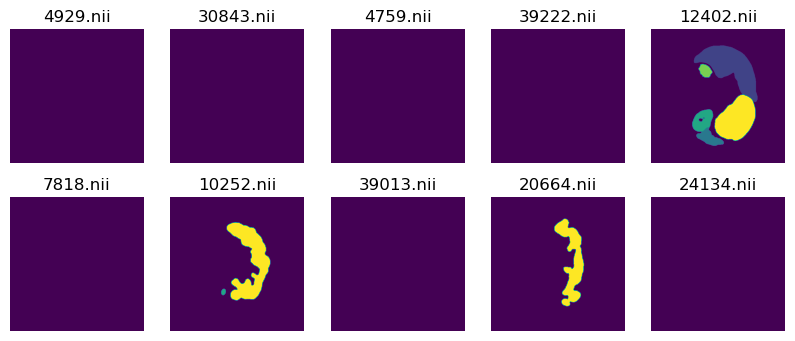

In [12]:
# Get a list of the Nibabel images in the directory
file_list = os.listdir(nib_img_dir)
file_list = [f for f in file_list if f.endswith('.nii')]

# Set the number of images to plot
num_images = 10

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(2, 5, figsize =(10, 4))

# Plot the specified number of images and their numbers
for i in range(num_images):
    # Load the Nibabel image
    img = nib.load(os.path.join(nib_img_dir, file_list[i]))

    # Get the pixel array of the Nibabel image
    pixel_array = img.get_fdata()

    # Plot the image and its number and filename
    axs[i // 5, i % 5].imshow(pixel_array[:, :, 0])
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(file_list[i])
plt.show()

**_As seen above, it's worth noting that the segmentation technique (segmentation) was used to remove noise and irrelevant information to focus on the relevant parts of the image. 3 images out of range 10 show the region of interest (ROI) and 7 CT scan images have uniform texture.This image contains a uniform background or a uniform object_.**

**_Overall, the interpretation of the above CT scan image depends on the context of the image and the application. In some cases, it may be desirable, while in other cases it may indicate a problem with the image quality or the preprocessing steps. However, it will be wise to talk to a medical professional or consult a domain expert when working with medical images, as they can provide valuable insights and guidance_**

**_In summary, image masks are an essential tool in medical image analysis, offering numerous benefits such as precise analysis, noise reduction, standardization, time-saving, and pin-point accuracy_.**

---------------

## _Read a DICOM image_:

**_DICOM is the international standard for medical images and related information. It defines the formats for medical images that can be exchanged with the data and quality necessary for clinical use. DICOM stands for Digital Imaging and Communications in Medicine and is recognized by the International Organization for Standardization as the ISO 12052 standard. DICOM is the standard format for most medical imaging devices used in hospitals and clinical care settings, including MRI, PET, CT, Xray, and ultrasound. For this reason, it is common that raw MRI data comes off the scanner in DICOM format_**.

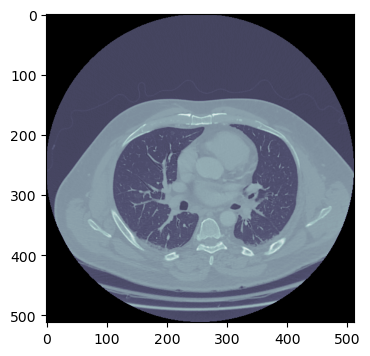

In [13]:
# Load the DICOM 2D image 229
slice_im19 = dicom.dcmread(os.path.join(dsroot, f'train_images/19/14374/229.dcm'))

# Get the pixel data
im_pixel = slice_im19.pixel_array

# Display the image
plt.figure(figsize =(4, 4))                      
plt.imshow(im_pixel)
plt.imshow(im_pixel, cmap ='bone')

# Plot images 229.dcm
plt.show()

## _Intensity values_

DICOM file contained compressed data. Autoconverting with gdcmconv (this warning is shown once for each directory)


gdcmconv: gdcm 3.0.22 $Date$


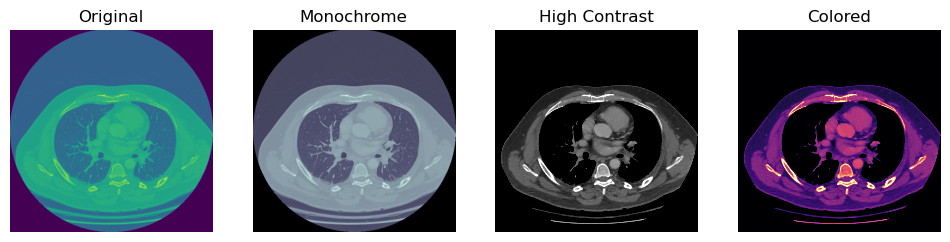

In [14]:
# Read single DICOM image with imread
im = iio.imread(os.path.join(dsroot, f'train_images/19/14374/229.dcm'))

# Plot three versions of chest dcm with image transformations
plt.rcParams['figure.figsize'] = (12, 8)

fig, axes = plt.subplots(nrows= 1, ncols= 4)
axes[0].imshow(im)
axes[1].imshow(im, cmap = 'bone')
axes[2].imshow(im, vmin = -200, vmax= 500, cmap = 'gray')
axes[3].imshow(im, vmin = -200, vmax= 500, cmap = 'magma')
axes[0].set_title('Original')
axes[1].set_title('Monochrome')
axes[2].set_title('High Contrast')
axes[3].set_title('Colored')
for ax in axes:
  ax.axis('off')
plt.show()

gdcmconv: gdcm 3.0.22 $Date$


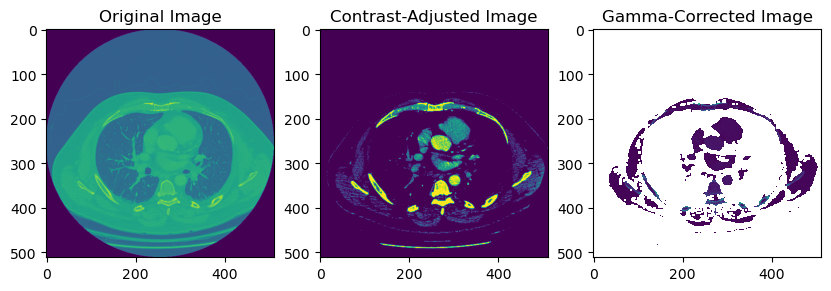

In [15]:
# Load an image
im = iio.imread(os.path.join(dsroot, f'train_images/19/14374/229.dcm'))

# Increase the contrast of the image by changing its minimum and maximum values
im_contrast = np.clip((im - 50) * 1.5, 0, 255).astype(np.uint8)

# Apply a gamma correction to the image
im_gamma = np.power(im / 255.0, 1.5) * 255.0

# Display the original image, contrast-adjusted image, and gamma-corrected image side by side
fig, axes = plt.subplots(1, 3, figsize =(10, 5))
axes[0].imshow(im)
axes[0].set_title('Original Image')
axes[1].imshow(im_contrast)
axes[1].set_title('Contrast-Adjusted Image')
axes[2].imshow(im_gamma)
axes[2].set_title('Gamma-Corrected Image')
plt.show()

## _Distribution of the intensity Histogram_

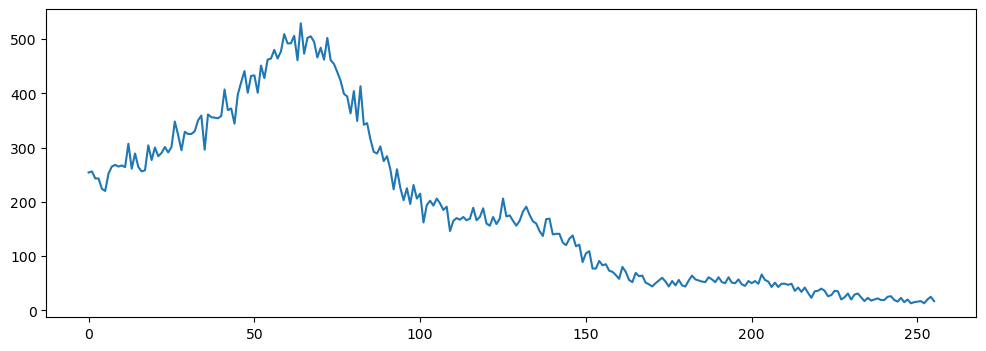

In [16]:
plt.figure(figsize =(12, 4))
slice_im19_hist = ndi.histogram(im_pixel,
                          min = 0,
                          max = 255,
                          bins =256)
plt.plot(slice_im19_hist, label ='Histogram')
plt.show()

**_The histogram above summarizes the distribution of intensity values in this CT scan 2D image_**.

**_It is important to note that the distribution of values in this slice is right skewed. We have many high values with low intensity between 0 and 75, and a wide range of high values above 75_**.

## _Histogram vs Histogram Equalized_

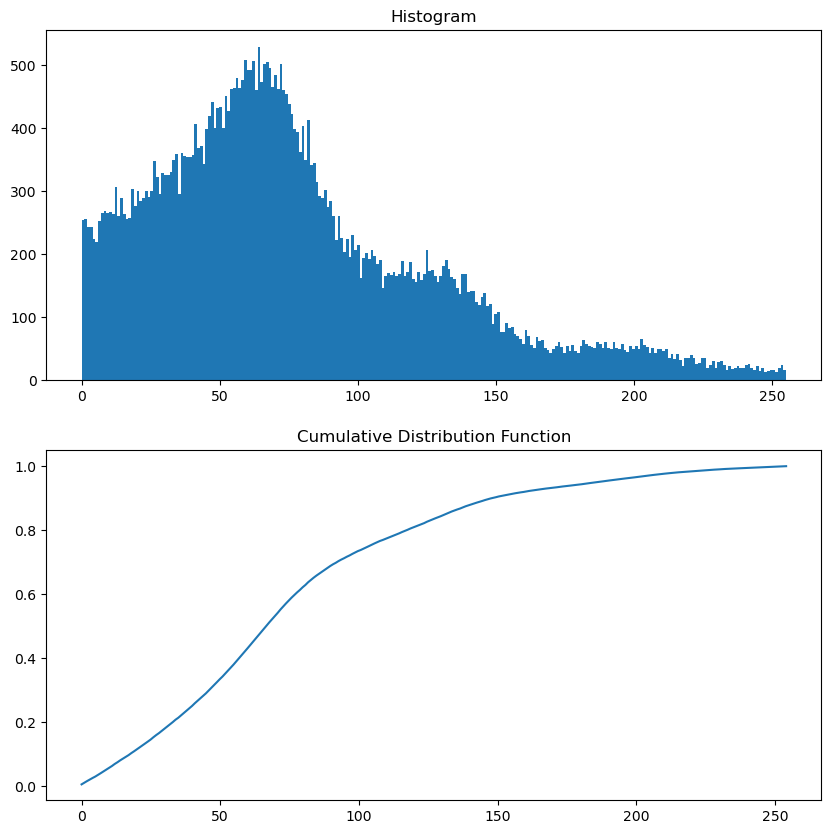

In [17]:
# Compute the histogram of the image
hist, bins = np.histogram(im_pixel.flatten(), bins =256, range =(0, 255))

# Compute the cumulative distribution function (CDF) of the histogram
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, figsize =(10, 10))
axes[0].hist(im_pixel.flatten(), bins =256, range =(0, 255))
axes[0].set_title('Histogram')
axes[1].plot(bins[:-1], cdf)
axes[1].set_title('Cumulative Distribution Function')
plt.show()

**_The area under a histogram is called the cumulative distribution function. It measures the frequency with which a given range of pixel intensities occurs. That is to say it redistributes values based on their abondance in the image_**

## _Equalization - Original image vs Image Equalized_

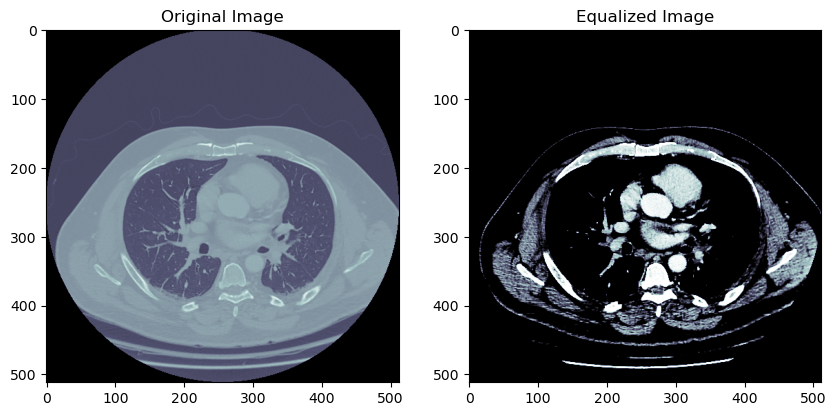

In [18]:
# Compute the histogram of the image
hist, bins = np.histogram(im.flatten(), bins =256, range =(0, 255))

# Compute the cumulative distribution function (CDF)
cdf = hist.cumsum() / hist.sum()

# Compute the equalized image using the CDF
im_equalized = np.interp(im_pixel.flatten(), bins[:-1], cdf) * 255
im_equalized = im_equalized.reshape(im_pixel.shape).astype(np.uint8)

# Display the original image and the equalized image side by side
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].imshow(im_pixel, cmap ='bone')
axes[0].set_title('Original Image')
axes[1].imshow(im_equalized, cmap ='bone')
axes[1].set_title('Equalized Image')
plt.show()

**_This technique involves redistributing the pixel values of the image to increase its contrast_**

## _Original Histogram vs Histogram Equalization_

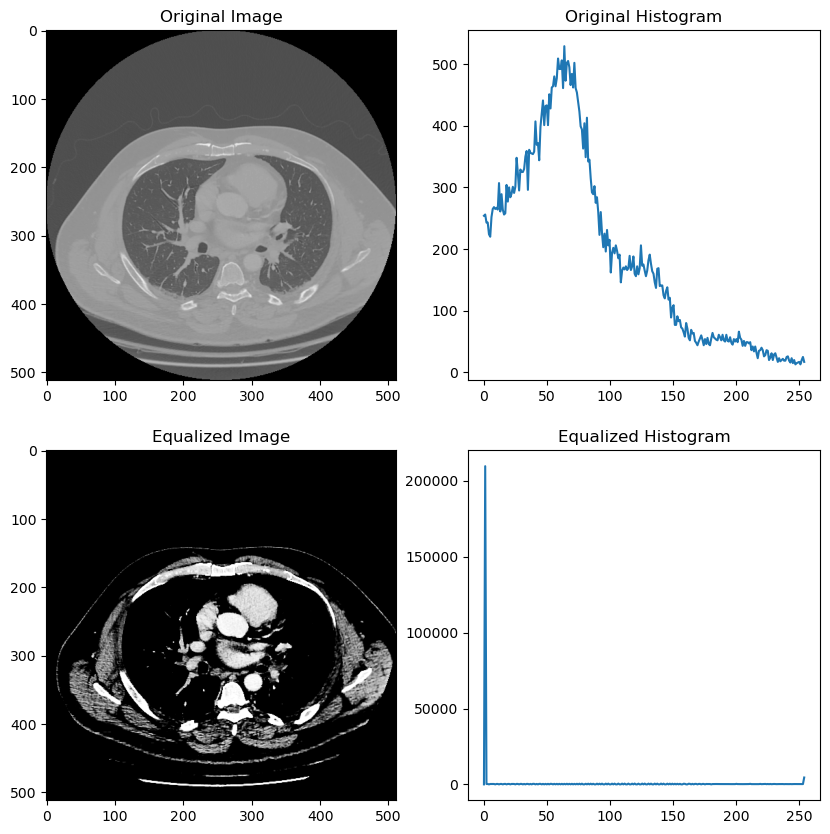

In [19]:
# Compute the histogram of the original image
hist_orig, bins_orig = np.histogram(im_pixel.flatten(), bins=256, range=(0, 255))

# Compute the cumulative distribution function (CDF) of the original image
cdf_orig = hist_orig.cumsum() / hist_orig.sum()

# Compute the equalized image using the CDF of the original image
im_equalized = np.interp(im_pixel.flatten(), bins_orig[:-1], cdf_orig) * 255
im_equalized = im_equalized.reshape(im_pixel.shape).astype(np.uint8)

# Compute the histogram of the equalized image
hist_eq, bins_eq = np.histogram(im_equalized.flatten(), bins = 256, range =(0, 255))

# Compute the cumulative distribution function (CDF) of the equalized image
cdf_eq = hist_eq.cumsum() / hist_eq.sum()

# Display the original image and histogram, and the equalized image and histogram side by side
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(im_pixel, cmap ='gray')
axes[0, 0].set_title('Original Image')
axes[0, 1].plot(bins_orig[:-1], hist_orig)
axes[0, 1].set_title('Original Histogram')
axes[1, 0].imshow(im_equalized, cmap ='gray')
axes[1, 0].set_title('Equalized Image')
axes[1, 1].plot(bins_eq[:-1], hist_eq)
axes[1, 1].set_title('Equalized Histogram')
plt.show()

**_As seen above, a single 2D image does not provide any detailed insight. It will be wise to retrieve more 2D images for this patient for better CT scan images analysis_**

-----------------

gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$


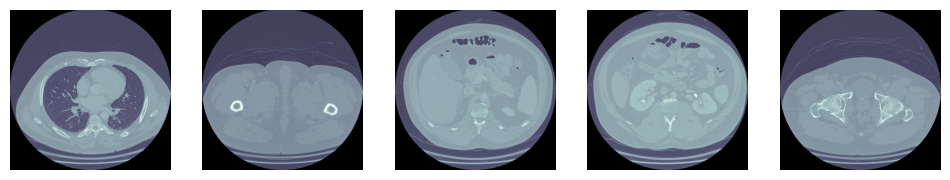

In [20]:
# Define the directory containing the medical images
img19_fpath = os.path.join(dsroot, f'train_images/19/14374')

# Get the list of image file names in the directory
image19_files = os.listdir(img19_fpath)

# Load and plot each image
plt.figure(figsize = (12, 12))

for i in range(5):
    image19_path = os.path.join(img19_fpath, image19_files[i])
    image19 = iio.imread(image19_path)
    plt.subplot(1,5, i+1)  # Create a 2x3 grid of subplots
    plt.imshow(image19, cmap ='bone')
    plt.axis("off")  # Optional: Remove the axis labels

plt.show()

## _Filters_

**_The aim of using filters is to help to visually modify or enhance image properties and identify different features present in an image like edges, as edges, corners, blobs, bends, etc_**.
**_This can help in understanding how filters modify or enhance image properties and extract valuable information from the pictures_**.

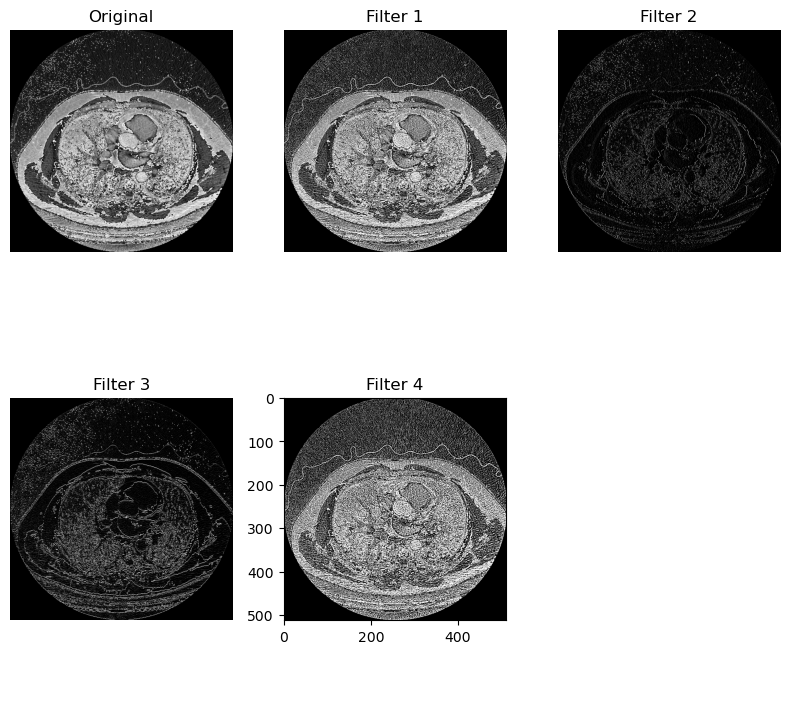

In [21]:
# Load the DICOM 2D image 229
im19 = dicom.dcmread(os.path.join(dsroot, f'train_images/19/14374/229.dcm'))

# define the filters
filter1 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
filter2 = np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])
filter3 = np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]])
filter4 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# extract the pixel data and convert to uint8
pixel_im = im19.pixel_array.astype("uint8")

# apply filters to the pixel data
filtered_data1 = cv2.filter2D(pixel_im, -1, filter1)
filtered_data2 = cv2.filter2D(pixel_im, -1, filter2)
filtered_data3 = cv2.filter2D(pixel_im, -1, filter3)
filtered_data4 = cv2.filter2D(pixel_im, -1, filter4)

# plot the original and filtered images
fig, axs = plt.subplots(2, 3, figsize = (8, 8))
axs[0, 0].imshow(pixel_im, cmap = plt.cm.gray)
axs[0, 0].set_title("Original")
axs[0, 0].axis('off')
axs[0, 1].imshow(filtered_data1, cmap = plt.cm.gray)
axs[0, 1].set_title("Filter 1")
axs[0, 1].axis('off')
axs[0, 2].imshow(filtered_data2, cmap = plt.cm.gray)
axs[0, 2].set_title("Filter 2")
axs[0, 2].axis('off')
axs[1, 0].imshow(filtered_data3, cmap = plt.cm.gray)
axs[1, 0].set_title("Filter 3")
axs[1, 0].axis('off')
axs[1, 1].imshow(filtered_data4, cmap = plt.cm.gray)
axs[1, 1].set_title("Filter 4")
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

**_The visualization (2D images/slices) only allows for a less detailed examination of each image but may not provide a comprehensive overview of the entire stacked 2D slices or all slices for the patient to dectect abdominal trauma_**.

-------

DICOM file contained compressed data. Autoconverting with gdcmconv (this warning is shown once for each directory)


gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$
gdcmconv: gdcm 3.0.22 $Date$


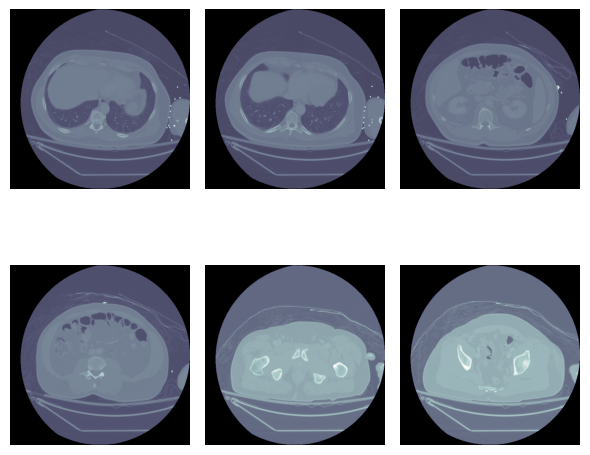

In [22]:
# Define the directory containing the medical images
img_path = os.path.join(dsroot, f'train_images/64263/40690/')

# Get the list of image file names in the directory
img_files = os.listdir(img_path)

# Load and plot each image
plt.figure(figsize = (6, 6))

for i in range(6):
    image_fpath = os.path.join(img_path, img_files[i])
    image = iio.imread(image_fpath)
    plt.subplot(2,3, i+1)  # Create a 2x3 grid of subplots
    plt.imshow(image, cmap ='bone')
    plt.axis("off")  # Optional: Remove the axis labels

plt.tight_layout()
plt.show()

**_As seen above, there are no inherent limitations to visualize only 2D images (slices) out of all slices for the patient. However, it is important to consider the context and purpose of the visualization. For example, if the goal is to compare the features of different images or regions, it may be necessary to visualize all images or a larger subset. In our case the 2D images we visualize don't provide any insights whatsover_**. 

**_Additionally, the specific 2D images that are chosen for visualization are not representative of the entire image  or dataset, leading to potential biases in the analysis or interpretation of the results_**.

## _Let us randonmly choose a segmentations and dicom CT scan images respectively_

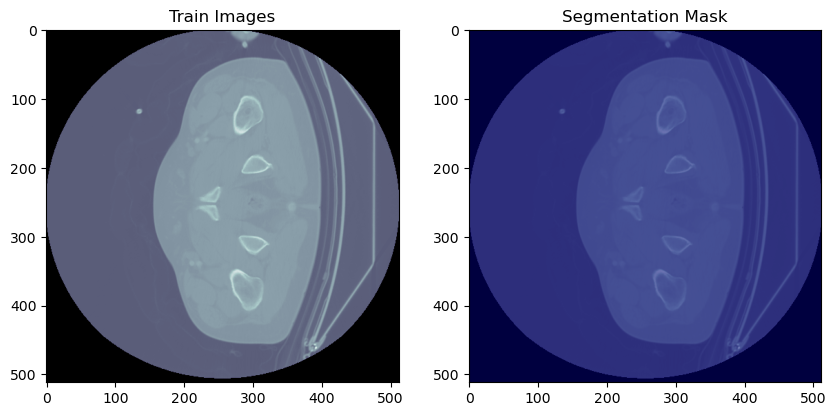

In [23]:
# Define the directory paths for the segmentation and train images
train_images = os.path.join(dsroot, 'train_images')
nib_img_dir= os.path.join(dsroot, 'segmentations')

# Get the list of image file names in the directory
seg_nib_img = os.listdir(nib_img_dir)

# Get a list of all the patient directories in the train image directory
patient_dirs = os.listdir(train_images)

# Choose a random patient directory
patient_dir = random.choice(patient_dirs)

# Get a list of all the series directories for the current patient
patient_dir = os.path.join(train_images, patient_dir)
series_dirs = os.listdir(patient_dir)

# Choose a random series directory for the current patient
series_dir = random.choice(series_dirs)

# Get a list of all the DICOM files in the current series directory
series_dir = os.path.join(patient_dir, series_dir)
dicom_slices = os.listdir(series_dir)

# Choose a random DICOM file from the current series directory
dicom_scan = random.choice(dicom_slices)

# Load the segmentation image and mask it
for nii_scan in seg_nib_img:
    # Load the nibabel image
    seg_img = nib.load(os.path.join(nib_img_dir, nii_scan))
    seg_data = seg_img.get_fdata()
    mask = seg_data > 0

# Load the DICOM file and rotate it 90 degrees to the right
dicom_img = dicom.dcmread(os.path.join(series_dir, dicom_scan))
dicom_array = np.rot90(dicom_img.pixel_array)

# Plot the images side by side
fig, ax = plt.subplots(1, 2, figsize =(10, 5))
ax[0].imshow(dicom_array, cmap ='bone')
ax[0].set_title('Train Images')
ax[1].imshow(dicom_array, cmap ='bone')
ax[1].imshow(np.rot90(mask[:, :, 0]), alpha = 0.5, cmap ='jet')
ax[1].set_title('Segmentation Mask')
plt.show()

## _Visualize side by side 15 images with the corresponding dicom_

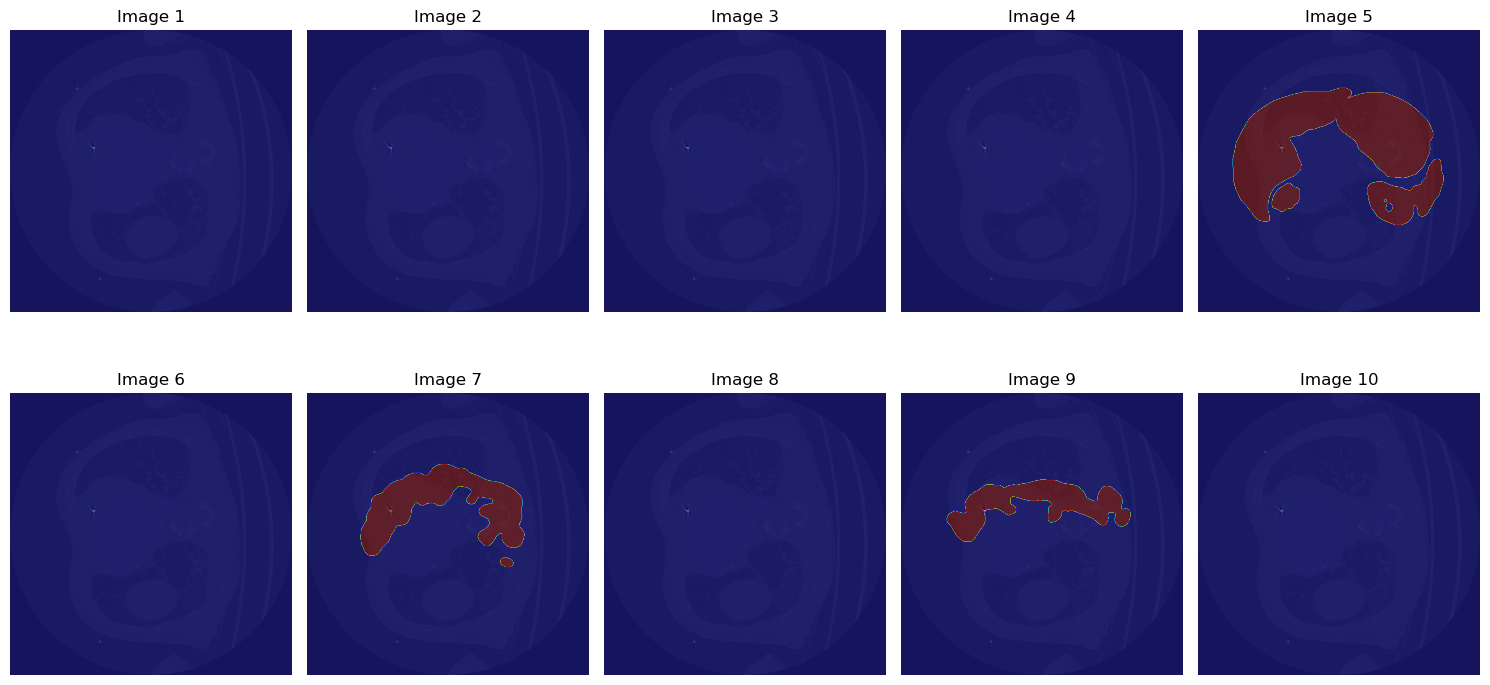

In [24]:
train_images = os.path.join(dsroot, 'train_images')
nib_img_dir= os.path.join(dsroot, 'segmentations')

# Get the list of image file names in the directory
seg_nib_img = os.listdir(nib_img_dir)

# Get a list of all the patient directories in the train image directory
patient_dirs = os.listdir(train_images)

# Choose a random patient directory
patient_dir = random.choice(patient_dirs)

# Get a list of all the series directories for the current patient
patient_dir = os.path.join(train_images, patient_dir)
series_dirs = os.listdir(patient_dir)

# Choose a random series directory for the current patient
series_dir = random.choice(series_dirs)

# Get a list of all the DICOM files in the current series directory
series_dir = os.path.join(patient_dir, series_dir)
dicom_slices = os.listdir(series_dir)

# Choose a random DICOM file from the current series directory
dicom_scan = random.choice(dicom_slices)

# Load the segmentation image and mask it
fig, ax = plt.subplots(2, 5, figsize =(15, 8))
for i in range(10):
    # Load the nibabel image
    seg_img = nib.load(os.path.join(nib_img_dir, seg_nib_img[i]))
    seg_data = seg_img.get_fdata()
    mask = seg_data > 0

    # Load the DICOM file and rotate it 90 degrees to the right
    dicom_img = dicom.dcmread(os.path.join(series_dir, dicom_scan))
    dicom_array = np.rot90(dicom_img.pixel_array)

    # Plot the images side by side
    row = i // 5
    col = i % 5
    ax[row, col].imshow(dicom_array, cmap ='bone')
    ax[row, col].imshow(np.rot90(mask[:, :, 0]), alpha = 0.5,cmap ='jet')
    ax[row, col].set_title(f'Image {i+1}')
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

## _Let's include the series ID & randomly select 5 CT scan images_

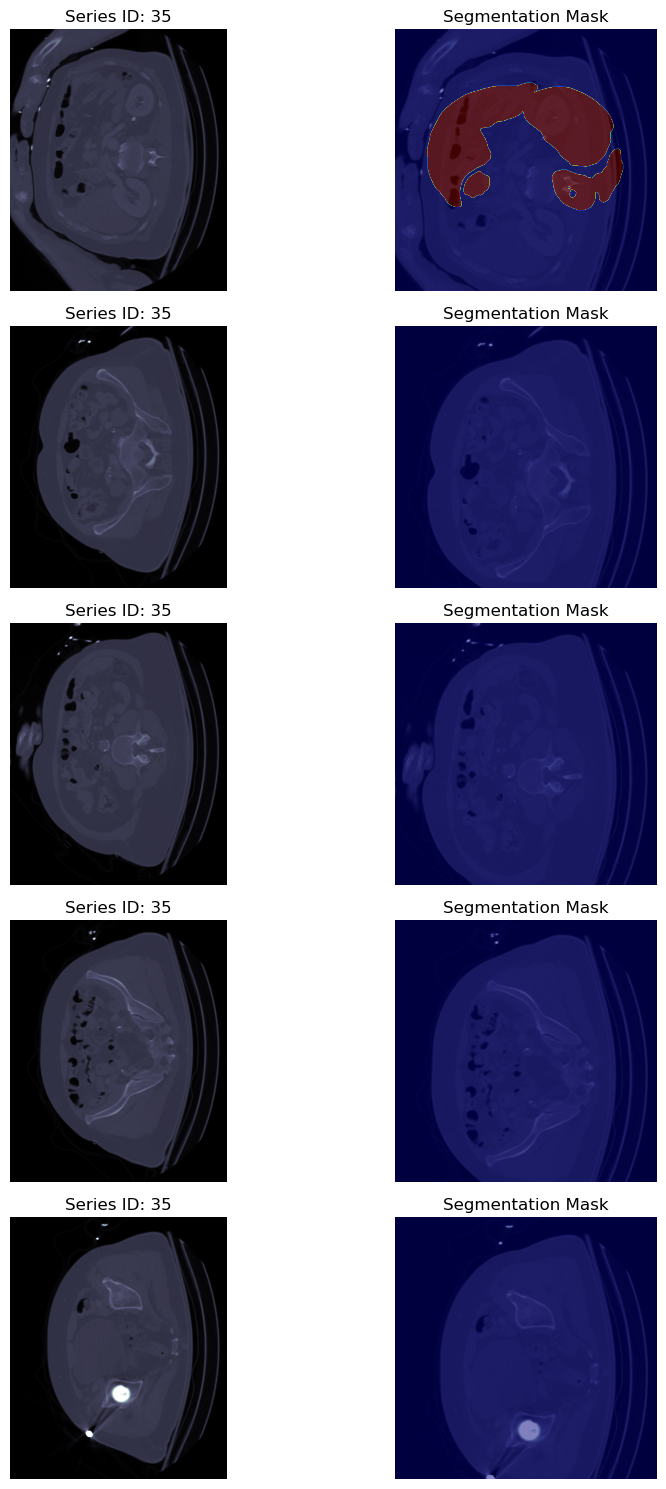

In [25]:
# Define the directory paths for the segmentation and train images
train_images = os.path.join(dsroot, 'train_images')
nib_img_dir= os.path.join(dsroot, 'segmentations')

# Get the list of image file names in the directory
seg_nib_img = os.listdir(nib_img_dir)

# Get a list of all the patient directories in the train image directory
patient_dirs = os.listdir(train_images)

# Choose a random patient directory
patient_dir = random.choice(patient_dirs)

# Get a list of all the series directories for the current patient
patient_dir = os.path.join(train_images, patient_dir)
series_dirs = os.listdir(patient_dir)

# Choose a random series directory for the current patient
series_dir = random.choice(series_dirs)

# Get a list of all the DICOM files in the current series directory
series_dir = os.path.join(patient_dir, series_dir)
dicom_slices = os.listdir(series_dir)

# Choose 5 random DICOM files from the current series directory
dicom_scans = random.sample(dicom_slices, 5)

# Load the segmentation images and mask them
seg_imgs = []
masks = []
for nii_scan in random.sample(seg_nib_img, 5):
    # Load the nibabel image
    seg_img = nib.load(os.path.join(nib_img_dir, nii_scan))
    seg_data = seg_img.get_fdata()
    mask = seg_data > 0
    seg_imgs.append(seg_data)
    masks.append(mask)

# Load the DICOM files and rotate them 90 degrees to the right
dicom_arrays = []
for dicom_scan in dicom_scans:
    dicom_img = dicom.dcmread(os.path.join(series_dir, dicom_scan))
    dicom_array = np.rot90(dicom_img.pixel_array)
    dicom_arrays.append(dicom_array)

# Plot the images side by side
fig, ax = plt.subplots(5, 2, figsize =(10, 15))
for i in range(5):
    ax[i, 0].imshow(dicom_arrays[i], cmap ='bone')
    ax[i, 0].set_title(f'Series ID: {dicom_img.SeriesNumber}')
    ax[i, 1].imshow(dicom_arrays[i], cmap ='bone')
    ax[i, 1].imshow(np.rot90(masks[i][:, :, 0]), alpha = 0.5, cmap ='jet')
    ax[i, 1].set_title('Segmentation Mask')
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
plt.tight_layout()
plt.show()

## _Let's redo the same experience and randomly select 10 more CT Scan including Serie ID_

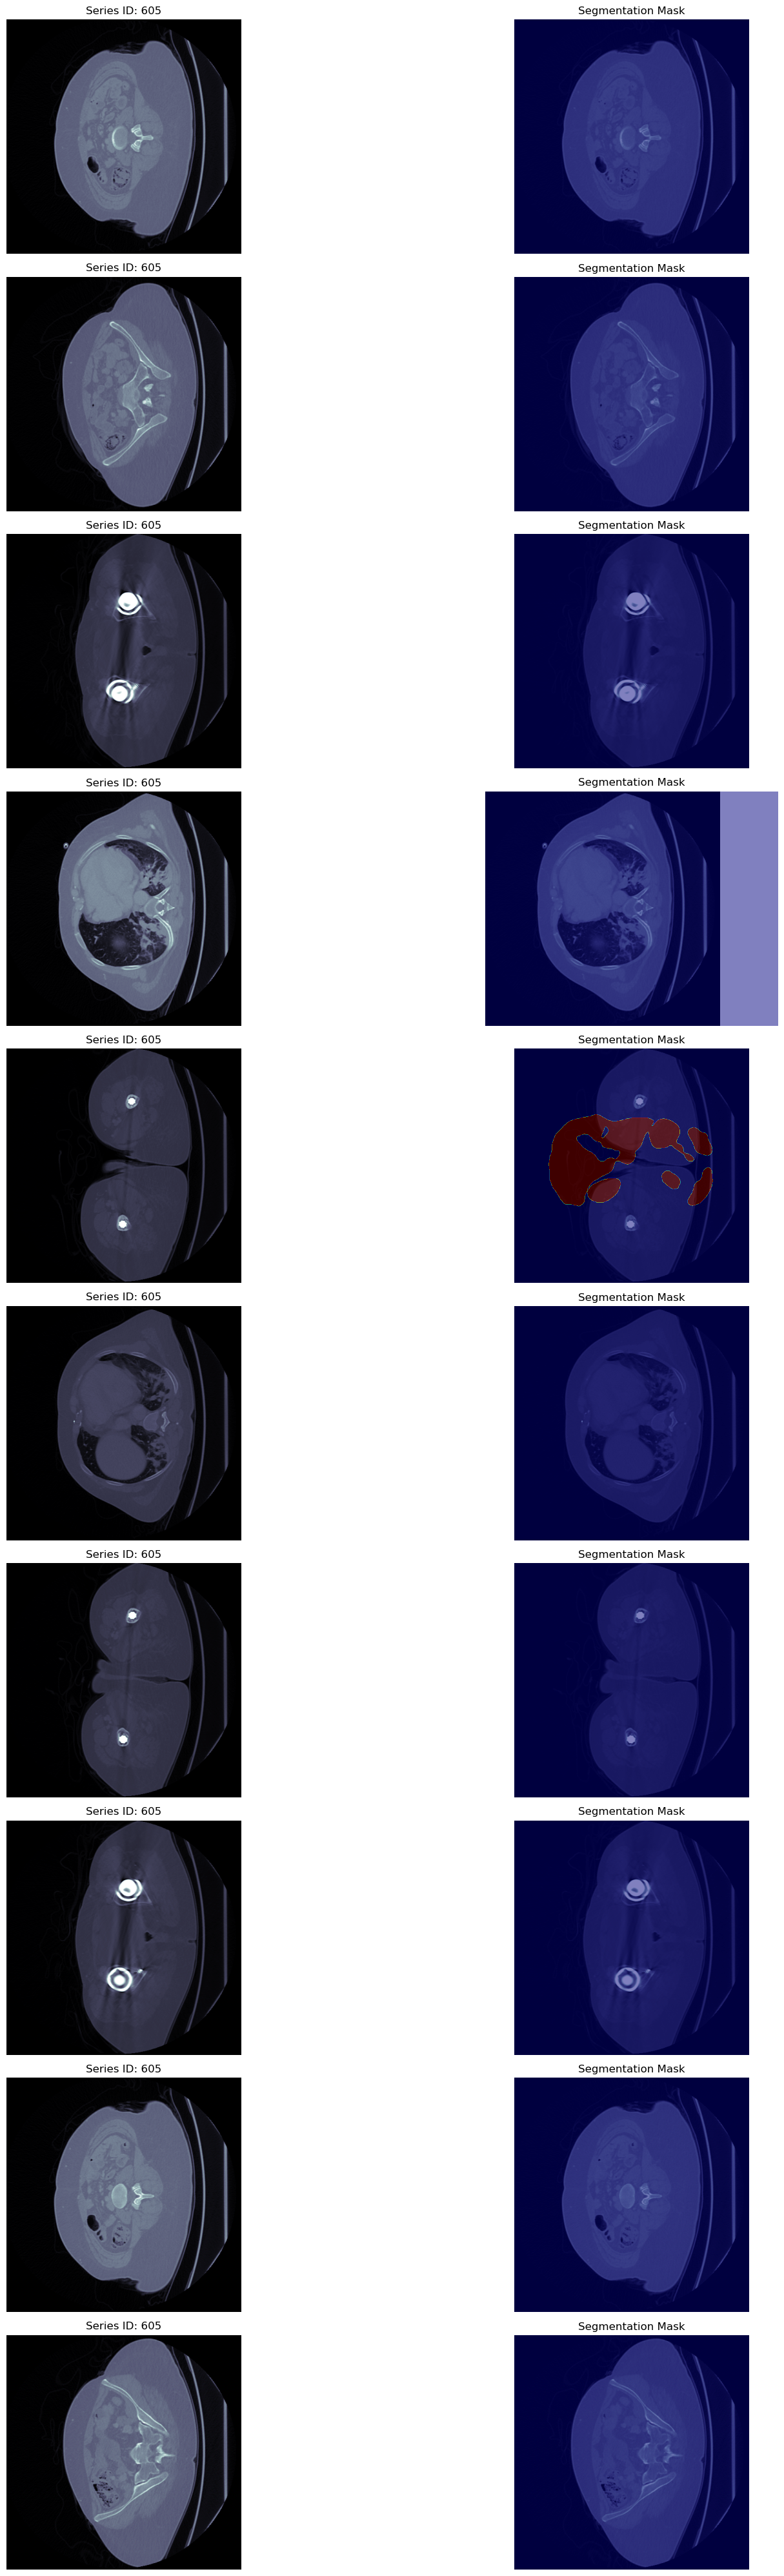

In [26]:
# Define the directory paths for the segmentation and train images
train_images = os.path.join(dsroot, 'train_images')
nib_img_dir= os.path.join(dsroot, 'segmentations')

# Get the list of image file names in the directory
seg_nib_img = os.listdir(nib_img_dir)

# Get a list of all the patient directories in the train image directory
patient_dirs = os.listdir(train_images)

# Choose a random patient directory
patient_dir = random.choice(patient_dirs)

# Get a list of all the series directories for the current patient
patient_dir = os.path.join(train_images, patient_dir)
series_dirs = os.listdir(patient_dir)

# Choose a random series directory for the current patient
series_dir = random.choice(series_dirs)

# Get a list of all the DICOM files in the current series directory
series_dir = os.path.join(patient_dir, series_dir)
dicom_slices = os.listdir(series_dir)

# Choose 10 random DICOM files from the current series directory
dicom_scans = random.sample(dicom_slices, 10)

# Load the segmentation images and mask them
seg_imgs = []
masks = []
for nii_scan in random.sample(seg_nib_img, 10):
    # Load the nibabel image
    seg_img = nib.load(os.path.join(nib_img_dir, nii_scan))
    seg_data = seg_img.get_fdata()
    mask = seg_data > 0
    seg_imgs.append(seg_data)
    masks.append(mask)

# Load the DICOM files and rotate them 90 degrees to the right
dicom_arrays = []
for dicom_scan in dicom_scans:
    dicom_img = dicom.dcmread(os.path.join(series_dir, dicom_scan))
    dicom_array = np.rot90(dicom_img.pixel_array)
    dicom_arrays.append(dicom_array)

# Plot the images side by side
fig, ax = plt.subplots(10, 2, figsize = (20, 40))
for i in range(10):
    ax[i, 0].imshow(dicom_arrays[i], cmap ='bone')
    ax[i, 0].set_title(f'Series ID: {dicom_img.SeriesNumber}')
    ax[i, 1].imshow(dicom_arrays[i], cmap ='bone')
    ax[i, 1].imshow(np.rot90(masks[i][:, :, 0]), alpha = 0.5, cmap ='jet')
    ax[i, 1].set_title('Segmentation Mask')
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    
plt.tight_layout()
plt.show()


---------------

## _Reading and Visualizing Structural 3D/Volume CT Scan images_

**_Using stacked slices to extract other planes (Sagittal and Coronal) is really handy. Radiologists can also benefit from scrolling through many slices when diagnosing. However, in order to appropriately display the three planes (Axial, Sagital and Coronal) and scroll over slices, we, as AI engineers, must first comprehend the meaning of the various properties. These characteristics include sampling, shape, and aspect ratio_**.

**_Although there are many methods and libraries for analyzing biodemical or radiology images, for this project we will focus on imageio_**

**_In this 3D CT scan image analysis part we will read structural CT scan for patient ID #19, serie_id #14374, visualize them as slices, and perform a couple of simple image processing operations on images of patient 19_**.

In [27]:
# Read the DICOM image using imageio.volread()
# Note: imageio.volread() can read a single file or a folder of files
id19_im_vol = iio.volread(img19_fpath,'DICOM')

Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using d

Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using d

Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using d

Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1/1346 files (0.1  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using d

Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 268/1346 files (19.9548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840

Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 548/1346 files (40.7%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 824/1346 files (61.2%  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1084/1346 files (80.5  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

Reading DICOM (examining files): 1301/1346 files (96.7  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1301/1346 files (96.7  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1301/1346 files (96.7  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1301/1346 files (96.7  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE). You can try using dcmtk or gdcm to convert the image.
Reading DICOM (examining files): 1301/1346 files (96.7  The dicom reader can only read files with uncompressed image data - not '1.2.840.10008.1.2.5' (RLE).

In [28]:
# image attributes
id19_im_vol.meta

Dict([('TransferSyntaxUID', '1.2.840.10008.1.2.1'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.2'),
      ('SOPInstanceUID', '1.2.123.12345.1.2.3.19.1.229'),
      ('ContentDate', '20230721'),
      ('ContentTime', '231217.173114 '),
      ('PatientID', '19'),
      ('StudyInstanceUID', '1.2.123.12345.1.2.3.19'),
      ('SeriesInstanceUID', '1.2.123.12345.1.2.3.19.14374'),
      ('SeriesNumber', 7),
      ('InstanceNumber', 229),
      ('ImagePositionPatient', (-228.0635, -221.2276, 1707.6)),
      ('ImageOrientationPatient', (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)),
      ('SamplesPerPixel', 1),
      ('Rows', 512),
      ('Columns', 512),
      ('PixelSpacing', (0.904, 0.904)),
      ('BitsAllocated', 16),
      ('BitsStored', 16),
      ('HighBit', 15),
      ('PixelRepresentation', 1),
      ('RescaleIntercept', 0.0),
      ('RescaleSlope', 1.0),
      ('PixelData', b'Deferred loading of pixel data'),
      ('shape', (673, 512, 512)),
      ('sampling', (0.7999999999999998, 0.904, 0.904

In [29]:
# plot interactive knee CT walkthrough
@widgets.interact(slice=(0,672))

def image19_dicom(slice = 0):
  fig, ax = plt.subplots(1,1, figsize = (5,5))
  ax.imshow(id19_im_vol[slice,:,:], cmap ='bone')
  ax.axis('off')

interactive(children=(IntSlider(value=0, description='slice', max=672), Output()), _dom_classes=('widget-inter…

## _Visualize a slice through different planes_

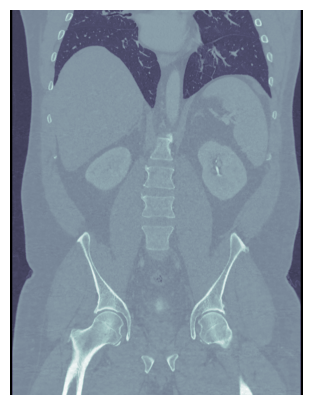

In [30]:
plt.figure(figsize = (5, 5))
plt.imshow(id19_im_vol[:, 300], cmap ='bone')
plt.axis('off')
plt.show()

## _Rotate the image_

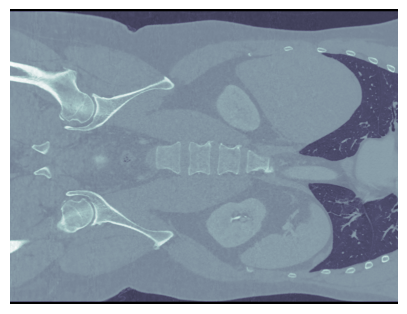

In [31]:
plt.figure(figsize = (5, 5))
plt.imshow(ndi.rotate(id19_im_vol[:, 300], 270), cmap ='bone')
plt.axis('off')
plt.show()

## _Coronal plane_

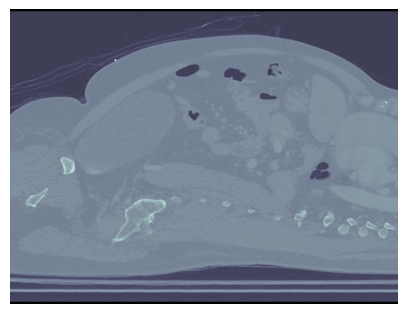

In [32]:
plt.figure(figsize = (5, 5))
plt.imshow(ndi.rotate(id19_im_vol[:, :, 300], 270), cmap ='bone')
plt.axis('off')
plt.show()

**Our histogram is highly right skewed with many low values and a wider range of high values. Skewed distributions are common in medical images.Background intensities are usualy low and take up lot of image space.**

## _Plotting a series of slices through a volume_

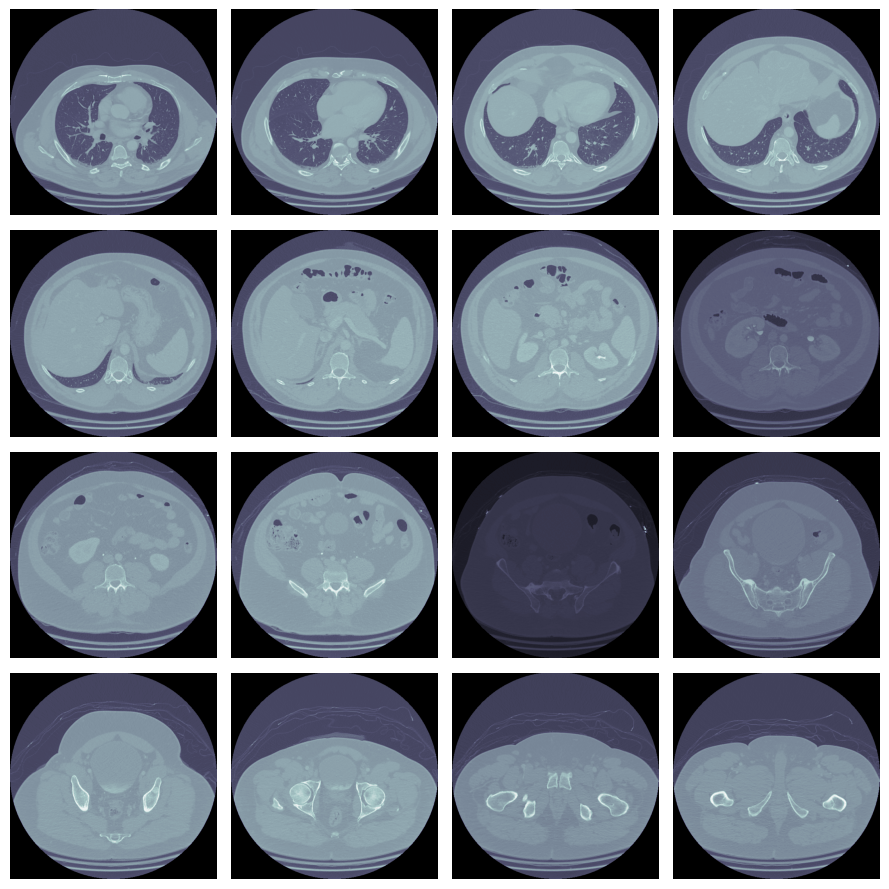

In [33]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = id19_im_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize = [9, 9])
for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(id19_im_vol[img, :, :], cmap ='bone')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## _Slice through a different axis_

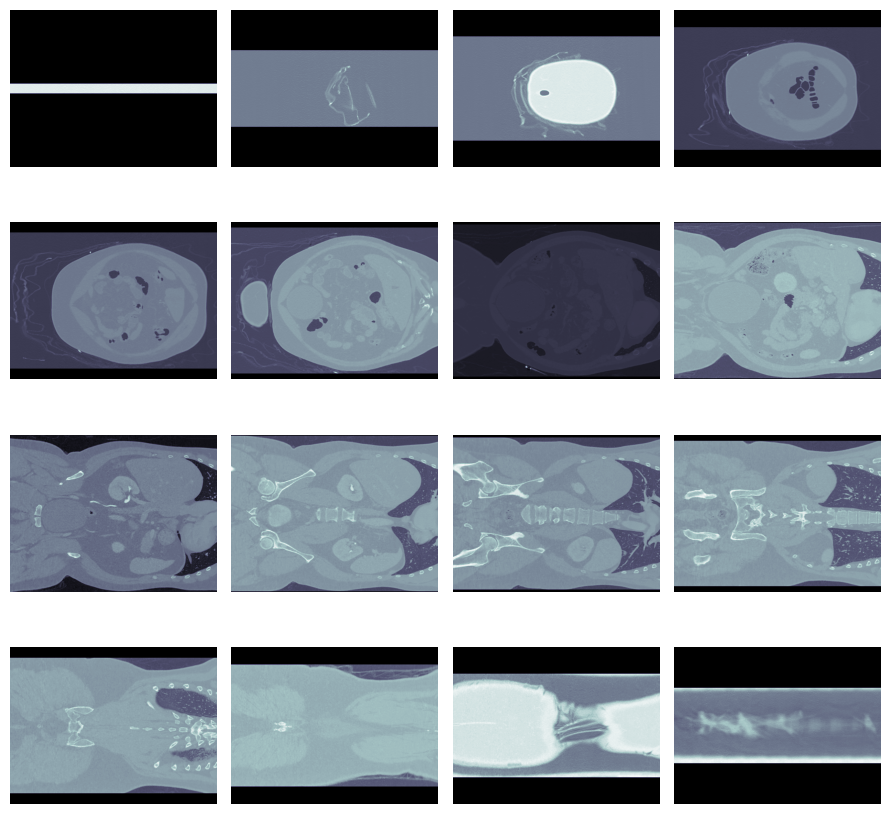

In [34]:
n_slice = id19_im_vol.shape[1]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize =[9, 9])
for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(id19_im_vol[:, img, :], 270), cmap ='bone')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## _Coronal plane_

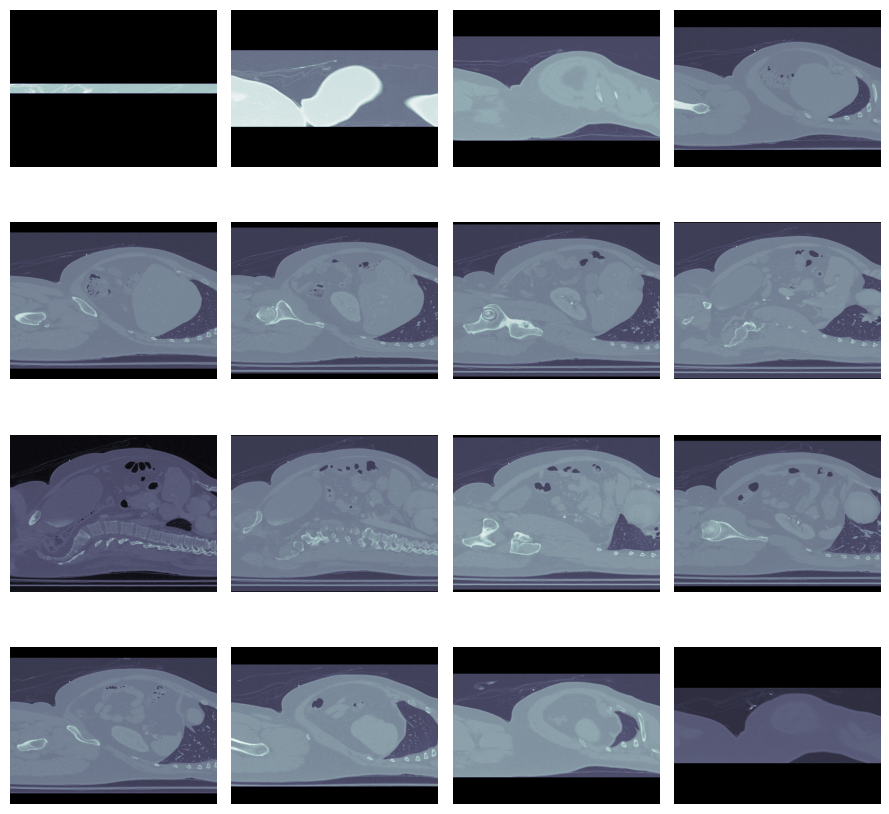

In [35]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = id19_im_vol.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size

start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize = [9, 9])
for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(id19_im_vol[:, :, img], 270), cmap ='bone')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## _Plotting an image histogram_

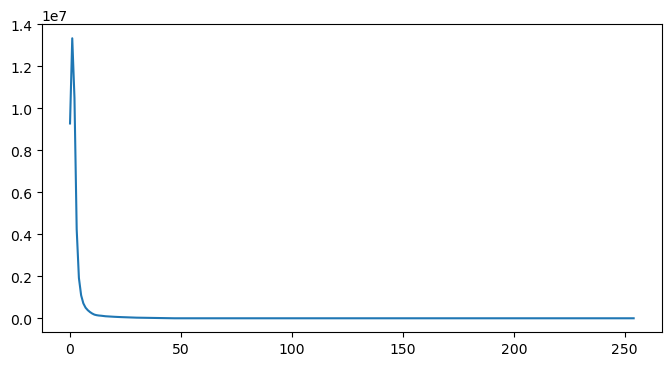

In [36]:
plt.figure(figsize = (8, 4))
plt.plot(ndi.histogram(id19_im_vol, min = 0, max = np.max(id19_im_vol), bins =255))
plt.show()

**_In summary, when the histogram of an image is smooth,it indicates that our image has a uniform textute, meaning that the pixel values are distributed more evenly across the image or an image contains a uniform background or a uniform object. This can have different interpretations depending on the context of the image and the application. Here are some possible interpretations_:**

  1. _The image has low contrast: A smooth histogram can indicate that the image has low contrast, meaning that the difference between the brightest and darkest pixels is small. This can happen, for example, when the image is underexposed or overexposed, or when the lighting conditions are poor_.
  2. _The image has uniform texture: A smooth histogram can also indicate that the image has uniform texture, meaning that the pixel values are similar across the image. This can happen, for example, when the image contains a uniform background or a uniform object_.

**_Overall, the interpretation of a smooth histogram depends on the context of the image and the application. In some cases, a smooth histogram may be desirable, while in other cases it may indicate a problem with the image quality or the preprocessing steps. Thus, tt will be wise medical professional or consult a domain expert when working with medical images, as they can provide valuable insights and guidance_**.

## _Mask an image_

In [37]:
gm_min = ((np.max(id19_im_vol)) / 50) * 10
gm_max = ((np.max(id19_im_vol)) / 50) * 20

im19_mask1 = np.where(id19_im_vol > gm_min, 1, 0)
im19_mask2 = np.where(id19_im_vol < gm_max, 1, 0)

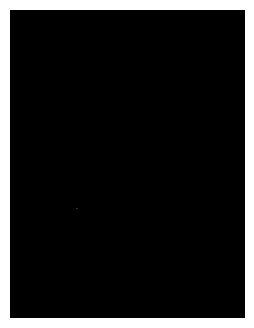

In [38]:
im19_mask = im19_mask1 + im19_mask2
im19_mask = np.where(im19_mask == 2, 1, 0)

plt.figure(figsize=(8, 4))
plt.imshow(im19_mask[:, 96, :], cmap ='gray')
plt.axis('off')
plt.show()

## _Image smoothing_

**_Below we will apply Gaussian smoothing to our CT scan volume using ndimage’s gaussian_filter() function. The one argument we need to supply is sigma, which is the width of the smoothing kernel, expressed as units of standard deviation. A larger sigma value will result in a smoother (blurrier) image, because we average over a larger number of voxels_**.

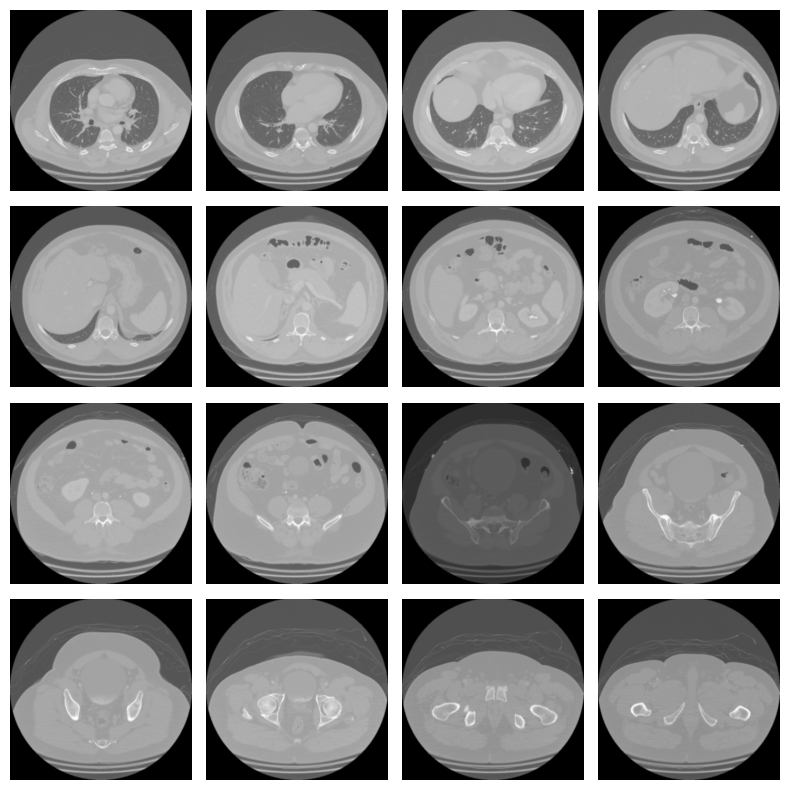

In [39]:
# Set sigma to 1
smoothed = ndi.gaussian_filter(id19_im_vol, sigma = 1)

# plot the image witch we apply the filter
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = id19_im_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size

start_stop = int((n_slice - plot_range) / 2)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize = [8, 8])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(smoothed[img, :, :], cmap ='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

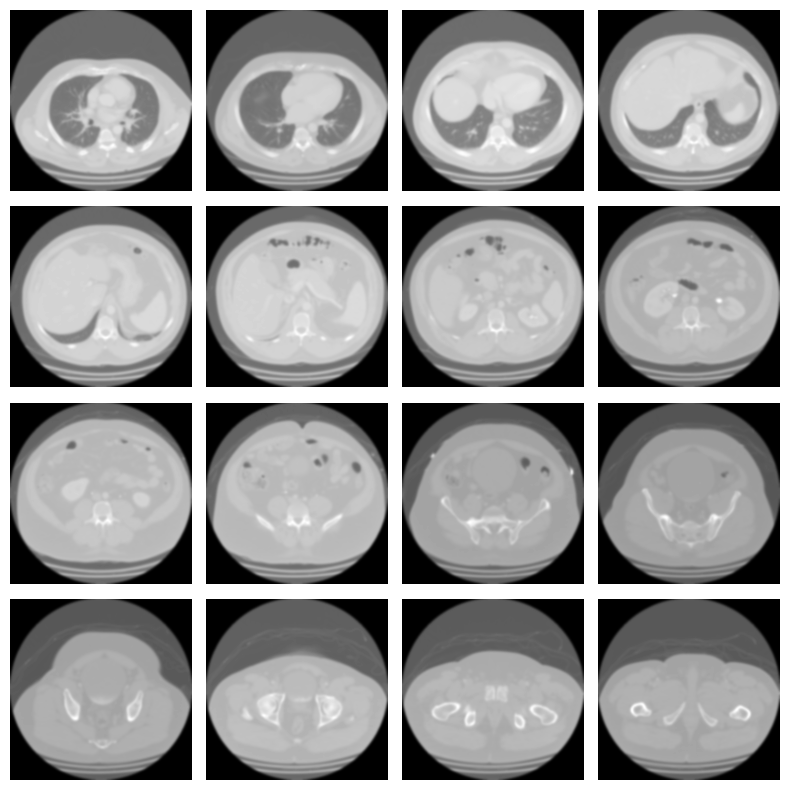

In [40]:
# Set sigma to 3
smoothed = ndi.gaussian_filter(id19_im_vol, sigma = 3)

# plot the image witch we apply the filter
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = id19_im_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size

start_stop = int((n_slice - plot_range) / 2)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize =[8, 8])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(smoothed[img, :, :], cmap ='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## _Segmenting smoothed images_

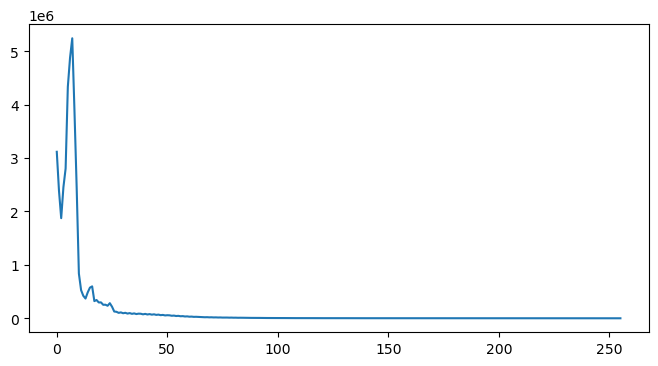

In [41]:
plt.figure(figsize = (8, 4))

filt = ndi.gaussian_filter(id19_im_vol, sigma = 2)
plt.plot(ndi.histogram(filt, min = 0, max = np.max(filt), bins = 256))
plt.show()

## _Let us animate our image along the axial plane_

In [42]:
# The shape of the stacked images in each plane (Axial, Coronal, and Sagittal, respectively)
n0, n1, n2 = id19_im_vol.meta.shape

# define sampling resolution along each axis
d0, d1, d2 = id19_im_vol.meta.sampling

# calculate axial aspect ratio
axial_asp = d1 / d2

# calculate sagittal aspect ratio
sagittal_asp = d0 / d1

# calculate coronal aspect ratio
coronal_asp = d0 / d2

# calculate field of view along each axis
axial = n0 * d0
coronal = n1 * d1
sagittal = n2 * d2

# Add a slider that starts with 0 and ends at the number of slices along the axial plane, n0=673.
@widgets.interact(axial_slice =(1, n0-1))

# Define the function that shows the images of the specified slice number.
# It starts with the 1th slice. And you can scroll over any slice

# using the slider.
def axial_slicer(axial_slice =60):
  fig, ax = plt.subplots(1, 1, figsize =(4, 4))

  # Show the image of the specified slice number in 'gray' color-map
  # and axial aspect ratio
  ax.imshow(id19_im_vol[axial_slice,:,:], cmap ='bone', aspect =axial_asp)
    
  # Don't show the axis
  ax.axis('off') 

interactive(children=(IntSlider(value=60, description='axial_slice', max=672, min=1), Output()), _dom_classes=…

**_LET'S INTERACTIVELY VISUALIZE & ANIMATE THE PATIENT ID #19 ALONG THE 3 PLANES_**

In [43]:
# Add three sliders that start with 0 and ends at the number of slices along each plane.
# Axial:    n0=673  slice
# Corornal: n1=512  slice
# Sagittal: n2=512  slice

@widgets.interact(axial_slice =(0,n0-1), coronal_slice =(0,n1-1),sagittal_slice =(0,n2-1))

def slicer(axial_slice, coronal_slice, sagittal_slice =100):
  fig, ax = plt.subplots(1, 3, figsize =(12, 12))

  # Show the specfied slice on the axial plane with 'gray' color-map
  # and axial aspect ratio.
  ax[0].imshow(id19_im_vol[axial_slice,:,:], cmap ='bone', aspect = axial_asp)
  ax[0].axis('off')
  ax[0].set_title('Axial')

  # Show the specified slice on the coronal plane with 'gray' color-map
  # and coronal aspect ratio.
  ax[1].imshow(id19_im_vol[:,coronal_slice,:], cmap ='bone', aspect = coronal_asp)
  ax[1].axis('off')
  ax[1].set_title('Coronal')

  # Show the specified slice on the sagittal plane with 'gray' color-map
  # and sagittal aspect ratio.
  ax[2].imshow(id19_im_vol[:,:,sagittal_slice], cmap ='bone', aspect = sagittal_asp)
  ax[2].axis('off')
  ax[2].set_title('Sagittal')

interactive(children=(IntSlider(value=336, description='axial_slice', max=672), IntSlider(value=255, descripti…

----------------

**_In sum, it's worth noting that to visualize the extracted CT Scan images or region of interest, 3D images represent the entire CT Scan for the patient and will lead to accurate analysis or interpretation_**

**_Based on the result above, it is allowed to conclude that the main difference between visualizing only few 2D CT scan images (dicom slices) and 3D medical images in nibabel or dicom format is the amount of information that can be observed and compared.When visualizing a subset of the images, you may miss out on important patterns or variations that could be present in the full 3D CT scan image_**.

**_It is important to consult with a medical professional or domain expert when working with medical images, as they can provide valuable insights and guidance on how to interpret and analyze the data. I will be more than happy to work with one of them_**

## _END OF BIOMEDICAL IMAGE ANALYSIS IN PYTHON_

-----------------